In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [4]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [5]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [6]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            with open(f'{ROOT_PATH}/results/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
                opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [7]:
opt_data

{0: {'MSE':                     message: ['requested number of basinhopping iterations completed successfully']
                      success: True
                          fun: 0.0193122692951781
                            x: [-5.011e+00  1.374e-01  2.269e-01  1.080e+00]
                          nit: 300
        minimization_failures: 81
                         nfev: 30330
                         njev: 6066
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 0.0193122692951781
                                      x: [-5.011e+00  1.374e-01  2.269e-01
                                           1.080e+00]
                                    nit: 2
                                    jac: [ 9.508e+02  3.056e+04  6.360e+03
                                           1.628e+04]
                                   nfev: 115

In [8]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 5*4*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1], 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True, 'noise_spec':{'noi_y':0.1}}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [9]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [10]:
pooling_fun = 'MSE'

In [11]:
outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

In [12]:
trials = 20
outs_mult = {k: [wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])   for _ in range(trials)]  for k in opt_data} 

Text(0.5, 1.0, 'subjects -->>1')

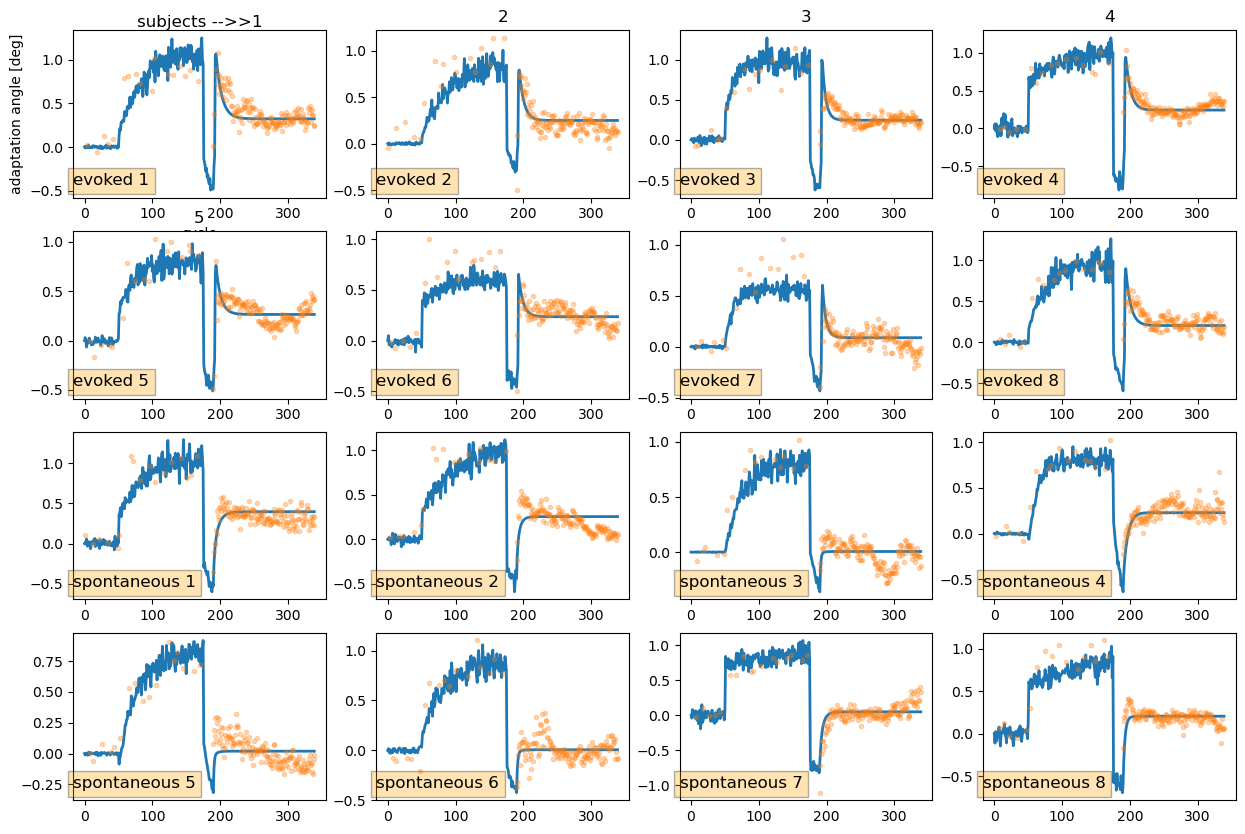

In [13]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [14]:
import pickle
# with open(f'{ROOT_PATH}/results/noisy_coin_fit12_noi_x0p05.pkl','wb') as f:
#     pickle.dump([outs,outs_mult],f)

Text(0.5, 1.0, 'subjects -->>1')

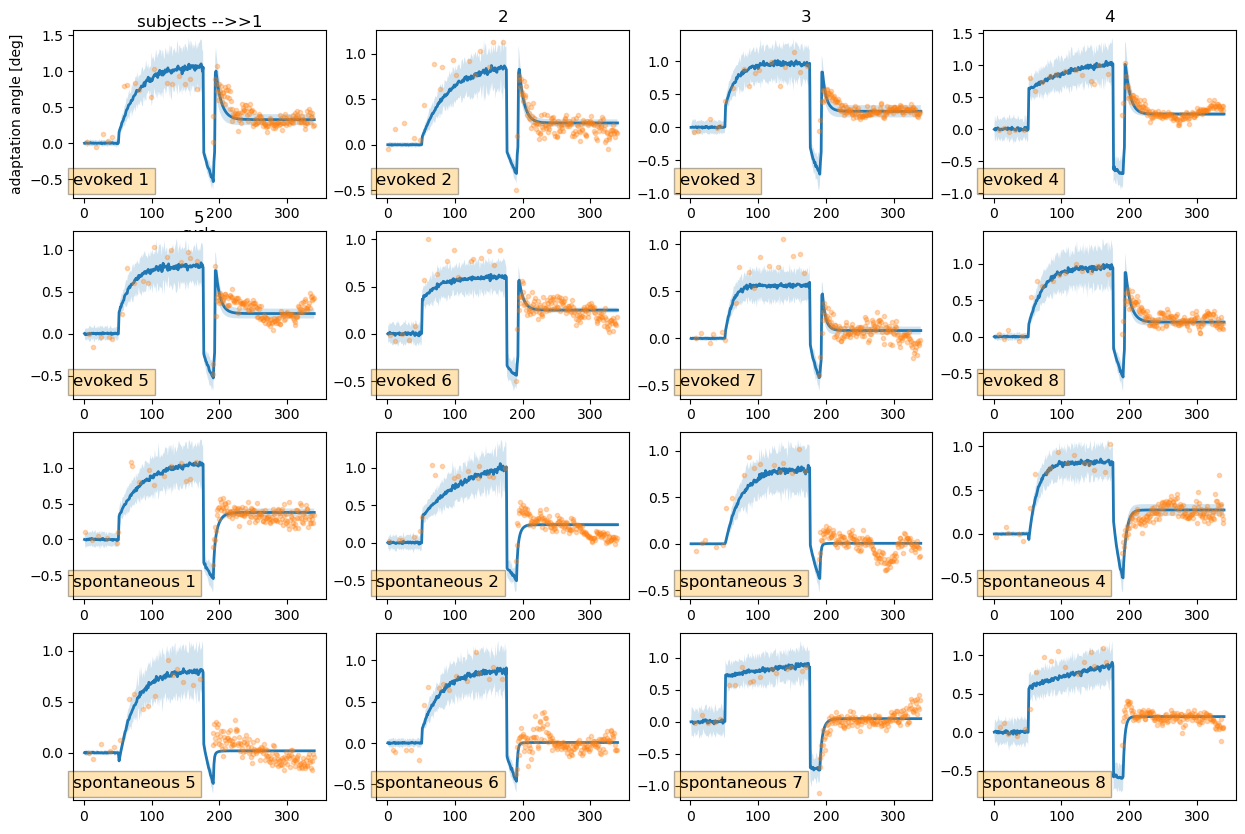

In [15]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
    k_draw = 3
    plt.plot(xdata_model,ydata_model_mean,linewidth=2)
    plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std, ydata_model_mean + k_draw*ydata_model_std, alpha=0.2)


    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


Text(0.5, 1.0, 'subjects -->>1')

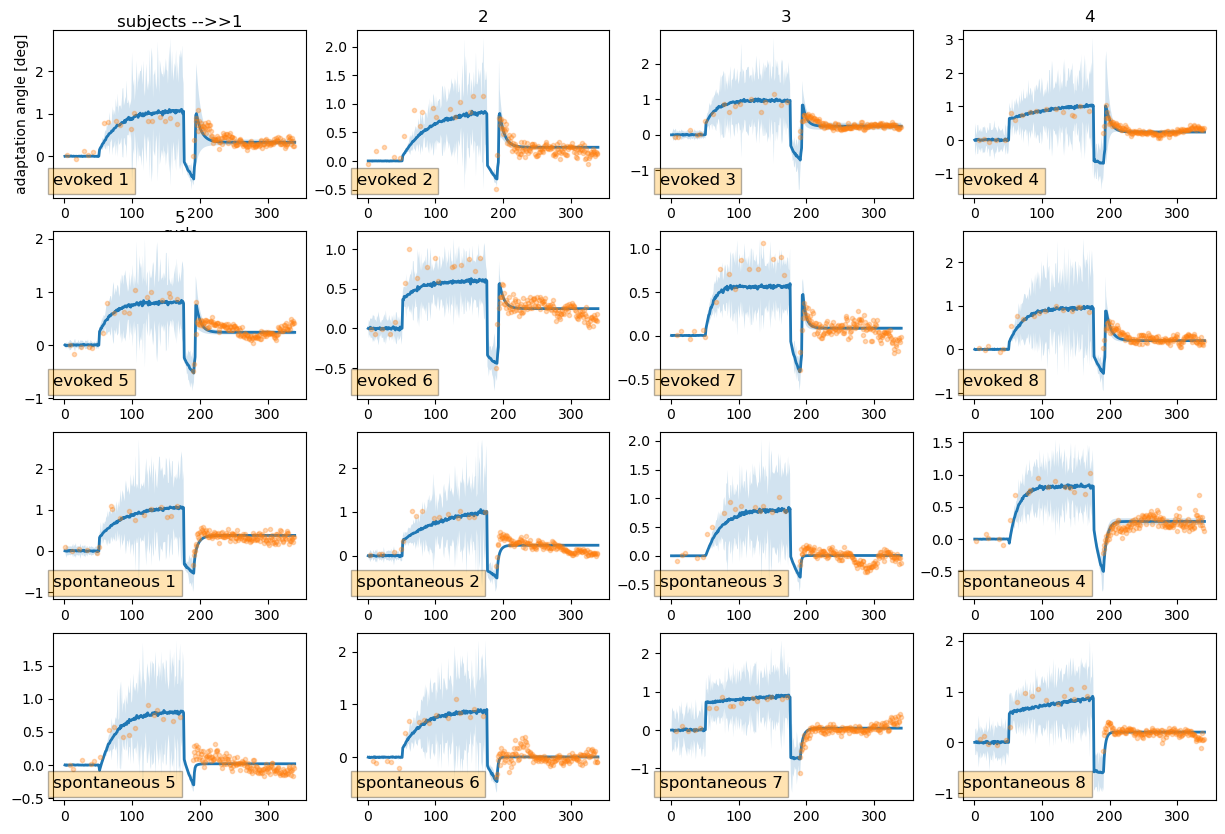

In [16]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
    k_draw = 100
    plt.plot(xdata_model,ydata_model_mean,linewidth=2)
    plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std**2, ydata_model_mean + k_draw*ydata_model_std**2, alpha=0.2)


    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [17]:
plt.figure(figsize=(15,10))
rms = lambda x: np.sqrt(np.mean(x**2))
data_std_0 = []
data_std_A = []
data_std_C = []
fit_std_0 = []
fit_std_A = []
fit_std_C = []
for k in opt_data:
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    data_std_0.append(np.nanstd(data[k][:50]))
    data_std_A.append(np.nanstd(data[k][50+125-50:50+125]))
    data_std_C.append(np.nanstd(data[k][-50:]))
    fit_std_0.append(rms(ydata_model_std[:50]))
    fit_std_A.append(rms(ydata_model_std[50+125-50:50+125]))
    fit_std_C.append(rms(ydata_model_std[-50:]))
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
#     k_draw = 3
#     plt.plot(xdata_model,ydata_model_mean,linewidth=2)
#     plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std, ydata_model_mean + k_draw*ydata_model_std, alpha=0.2)


#     plt.plot(data[k],'.', alpha=0.3)
#     if k<5: plt.title(f'{k+1}')
#     plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
#                  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
#                  bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# plt.ylabel('adaptation angle [deg]')
# plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# # plt.legend(['model','validation data','fitted data'])    
    
# # plt.plot(data[:80,0],'.')
# # plt.plot(smooth_signal(data[:,0],3))


<Figure size 1500x1000 with 0 Axes>

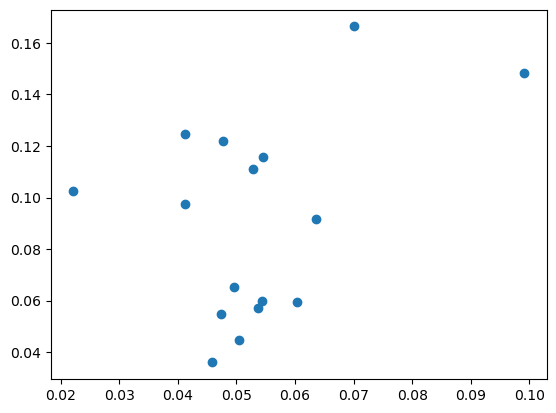

In [18]:
plt.plot(data_std_0, data_std_A, 'o')

(array([1., 1., 1., 3., 1., 0., 0., 0., 1., 1., 1., 1., 1., 2., 0., 0., 0.,
        1., 0., 1.]),
 array([0.03601425, 0.04253313, 0.04905201, 0.05557089, 0.06208977,
        0.06860865, 0.07512753, 0.08164641, 0.08816529, 0.09468417,
        0.10120305, 0.10772193, 0.11424081, 0.12075969, 0.12727857,
        0.13379745, 0.14031633, 0.14683521, 0.15335408, 0.15987296,
        0.16639184]),
 <BarContainer object of 20 artists>)

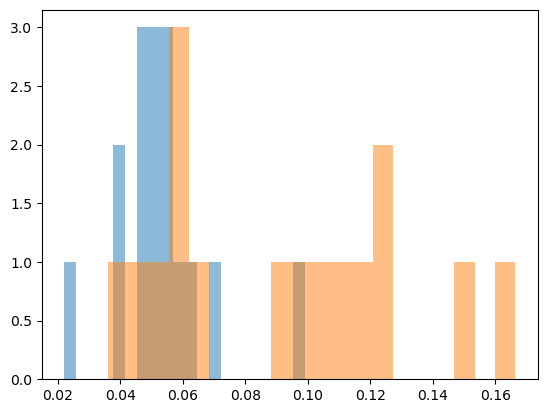

In [19]:
bins = np.linspace(0, 0.15, 10)
plt.hist(data_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(data_std_A, bins=20, alpha=0.5, label='std A')

In [30]:
from scipy.stats import ranksums
# print(f'p-value for ranksum: {ranksums(data_std_0, data_std_A).pvalue}')
print(f'DATA: mean std 0: {np.mean(data_std_0):0.3}, mean std A: {np.mean(data_std_A):0.3}   p-val (ranksum): {ranksums(data_std_0, data_std_A).pvalue:0.4}')
print(f'DATA: mean std A: {np.mean(data_std_A):0.3}, mean std C: {np.mean(data_std_C):0.3}   p-val (ranksum): {ranksums(data_std_A, data_std_C).pvalue:0.4}')

print(f'FIT: mean std 0: {np.mean(fit_std_0):0.3}, mean std A: {np.mean(fit_std_A):0.3}   p-val (ranksum): {ranksums(fit_std_0, fit_std_A).pvalue:0.4}')
print(f'FIT: mean std A: {np.mean(fit_std_A):0.3}, mean std C: {np.mean(fit_std_C):0.3}   p-val (ranksum): {ranksums(fit_std_A, fit_std_C).pvalue:0.4}')




# print(f'p-value for ranksum test between std 0 (fit) and std A (fit): {ranksums(fit_std_0, fit_std_A).pvalue}')
# print(f'mean fit std 0: {np.mean(fit_std_0)}, mean fit std A: {np.mean(fit_std_A)}')

DATA: mean std 0: 0.0534, mean std A: 0.0911   p-val (ranksum): 0.002569
DATA: mean std A: 0.0911, mean std C: 0.0766   p-val (ranksum): 0.3271
FIT: mean std 0: 0.026, mean std A: 0.0821   p-val (ranksum): 3.557e-06
FIT: mean std A: 0.0821, mean std C: 0.0123   p-val (ranksum): 1.406e-06


(array([2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2., 1., 0., 1., 1., 2.,
        2., 0., 1.]),
 array([0.05476473, 0.05714217, 0.05951961, 0.06189705, 0.06427449,
        0.06665194, 0.06902938, 0.07140682, 0.07378426, 0.0761617 ,
        0.07853915, 0.08091659, 0.08329403, 0.08567147, 0.08804891,
        0.09042635, 0.0928038 , 0.09518124, 0.09755868, 0.09993612,
        0.10231356]),
 <BarContainer object of 20 artists>)

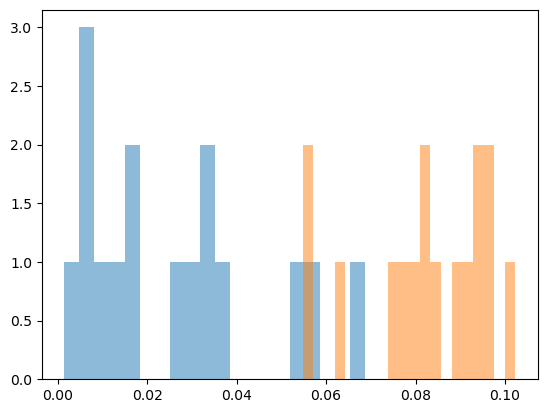

In [31]:
bins = np.linspace(0, 0.15, 10)
plt.hist(fit_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(fit_std_A, bins=20, alpha=0.5, label='std A')

(array([1., 1., 1., 2., 1., 1., 1., 1., 0., 0., 0., 2., 2., 1., 0., 1., 0.,
        0., 0., 1.]),
 array([-0.23961848, -0.15103679, -0.06245509,  0.0261266 ,  0.11470829,
         0.20328999,  0.29187168,  0.38045338,  0.46903507,  0.55761676,
         0.64619846,  0.73478015,  0.82336185,  0.91194354,  1.00052524,
         1.08910693,  1.17768862,  1.26627032,  1.35485201,  1.44343371,
         1.5320154 ]),
 <BarContainer object of 20 artists>)

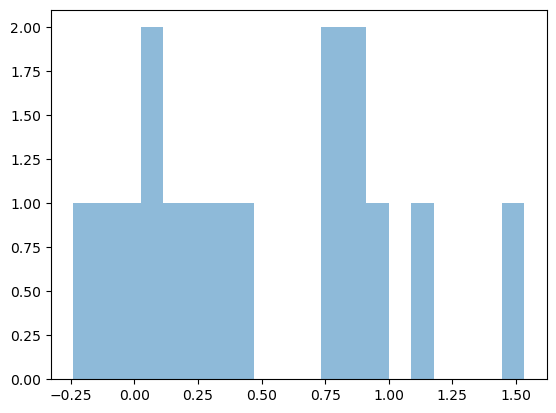

In [22]:
plt.hist(np.log(np.array(data_std_A)/np.array(data_std_0)), bins=20, alpha=0.5, label='std A')

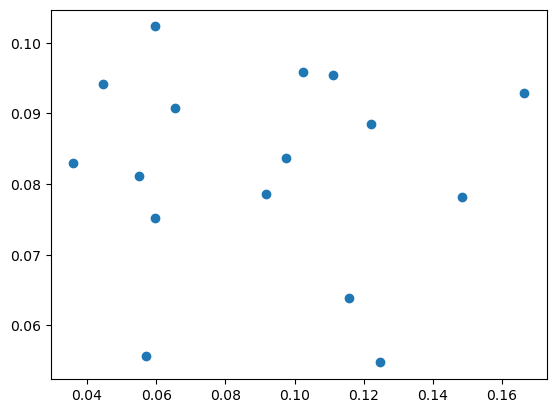

In [23]:
plt.plot(data_std_A, fit_std_A, 'o')

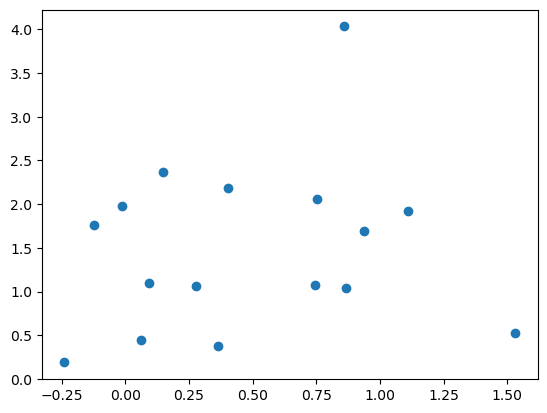

In [24]:
plt.plot(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)), 'o')

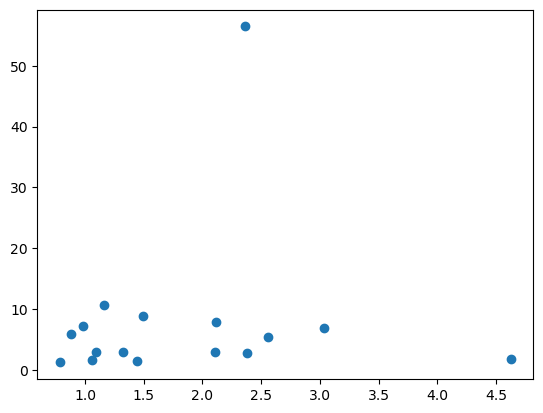

In [25]:
plt.plot(np.array(data_std_A)/np.array(data_std_0), np.array(fit_std_A)/np.array(fit_std_0), 'o')

In [26]:
from scipy.stats import spearmanr, pearsonr

In [27]:
corr_lograt = pearsonr(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)))
corr_rat = pearsonr(np.array(data_std_A)/np.array(data_std_0), np.array(fit_std_A)/np.array(fit_std_0))

In [28]:
corr_lograt

PearsonRResult(statistic=0.16071445214313196, pvalue=0.5521128541653237)

In [29]:
corr_rat

PearsonRResult(statistic=0.10968176557381004, pvalue=0.6859463735673768)

In [32]:
[opt_data[k][pooling_fun]['x'] for k in opt_data]

[array([-5.01053433,  0.13739387,  0.22685968,  1.07986433]),
 array([-5.15911135,  0.09829468,  0.21047876,  0.89340925]),
 array([-4.79211431,  0.34222185,  0.32133725,  0.97265242]),
 array([-5.36939678,  0.55963168,  0.28094873,  1.1       ]),
 array([-4.88786749,  0.3138048 ,  0.29407997,  0.81238703]),
 array([-5.06016588,  0.59196867,  0.49999951,  0.60972461]),
 array([-4.62876725,  0.14077746,  0.24326095,  0.56858945]),
 array([-4.90059661,  0.1714118 ,  0.19678172,  0.96876432]),
 array([-5.16386762,  0.29984328,  0.29430323,  1.1       ]),
 array([-5.36178625,  0.30834761,  0.25907268,  1.09999761]),
 array([-4.91289604,  0.01953876,  0.01      ,  0.81521124]),
 array([-4.75353074, -0.1       ,  0.5       ,  0.82247559]),
 array([-4.9268377 , -0.1       ,  0.02984393,  0.81246889]),
 array([-4.99335444,  0.19282511,  0.01      ,  0.88796931]),
 array([-5.65829185,  0.70915466,  0.14863431,  1.00669739]),
 array([-5.82408124,  0.53150675,  0.5       ,  1.1       ])]